In [ ]:
#Config
import os
from typing import Dict, Tuple
from src.xdream.core.generator import DeePSiMGenerator
from src.xdream.core.optimizer import CMAESOptimizer, GeneticOptimizer, HybridOptimizer
from src.xdream.core.scorer import ActivityScorer
from src.xdream.core.subject import TorchNetworkSubject
from src.xdream.core.utils.dataset import MiniImageNet, NaturalStimuliLoader
from src.xdream.core.utils.io_ import read_json
from src.xdream.core.utils.logger import LoguruLogger
from src.xdream.core.utils.probe import RecordingProbe
from src.xdream.core.utils.torch_net_load_functs import torch_load
lsettings_fp = 'path/to/local_settings.json'
local_setting = read_json(lsettings_fp)

OUT_DIR         : str = local_setting.get('out_dir',      None)
WEIGHTS         : str = local_setting.get('weights',      None)
DATASET         : str = local_setting.get('dataset',      None)

CUSTOM_WEIGHTS  : str = local_setting.get('custom_weights',  None)
device = 'cuda'
PARAM_net_name = 'resnet50' 
path2CustomW = ''##os.path.join(CUSTOM_WEIGHTS, PARAM_net_name, 'imagenet_l2_3_0.pt')

generator = DeePSiMGenerator(
    root    = str(WEIGHTS),
    variant = str('fc7') # type: ignore
).to(device)

# Create a on-the-fly network subject to extract all network layer names
layer_info: Dict[str, Tuple[int, ...]] = TorchNetworkSubject(
    network_name=str(PARAM_net_name)
).layer_info

# Probe
record_target = {'56_linear_01': [1]}  # 13_linear_03 for alexnet
probe = RecordingProbe(target = record_target) # type: ignore

# Subject with attached recording probe
sbj_net = TorchNetworkSubject(
    record_probe=probe,
    network_name=PARAM_net_name,
    t_net_loading = torch_load,
    custom_weights_path = path2CustomW#os.path.join(CUSTOM_WEIGHTS, PARAM_net_name, path2CustomW)
)

# Set the network in evaluation mode
sbj_net.eval()

scoring_units = {'56_linear_01': [0]}
scorer = ActivityScorer(
    scoring_units=scoring_units,
    units_reduction='mean',  # type: ignore
    layer_reduction='mean', # type: ignore
)
n_iter = 500
pso_params = {
    'inertia_max': 0.99,
    'inertia_min': 0.95,
    'cognitive': 2.5,
    'social': 2,
    'v_clip': 0.15,
    'num_informants': 15,
   
    'max_iterations' :n_iter,
    #'first_PSO_interval' : 0.6,
    #'second_PSO_interval' : 0.9,  
}
    


#--- OPTIMIZER ---
optim = HybridOptimizer(
            codes_shape=generator.input_dim,
            pop_size=50,    
            rnd_seed=50000,     
            pso_params=pso_params,        
            max_iterations=n_iter,       
            diversity_threshold=0.01,
            stagnation_threshold=0.01,
            first_PSO_interval = 0.6,
            second_PSO_interval= 0.9
            )



#optim = CMAESOptimizer(
#     codes_shape = generator.input_dim,
#     rnd_seed    = 50000,
#     pop_size    = 50,
#     sigma0      = 1.0,
#)
#optim = GeneticOptimizer(
#    codes_shape  = generator.input_dim,
#    rnd_seed     = 50000,
#    pop_size     = 50,
#    rnd_scale    = 1,
#    mut_size     = 0.3,
#    mut_rate     = 0.3,
#    allow_clones = True,
#    n_parents    = 4
#)


logger = LoguruLogger(to_file=False)


template = [True]
use_nat  = template.count(False) > 0

# Create dataset and loader
dataset  = MiniImageNet(root=DATASET) #RandomImageDataset(n_img=100, img_size=(224, 224,))# 

nat_img_loader   = NaturalStimuliLoader(
    dataset=dataset,
    template=template,
    shuffle=True,
    batch_size=64
)

data = {
    "dataset"      : dataset if use_nat else None,
    "render"       : False,
    "close_screen" : True,
    "use_nat"      : use_nat
}



2025-07-21 09:28:41.164 | INFO     | src.xdream.core.utils.logger:_info:417 - Creating experiment directory .
2025-07-21 09:28:41.165 | INFO     | src.xdream.core.utils.logger:_info:417 - Running...
/home/gamerio/miniconda3/envs/psoXdream/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gamerio/miniconda3/envs/psoXdream/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2025-07-21 09:28:41.575 | INFO     | src.xdream.core.utils.logger:_info:417 - MaximizeActivity[maximize_activity]: [  1/500] ( 0.20%)  | best score: 3.6 | avg score: 1.1
2025-07-21 09:28:41.743 | INFO     | src.xdream.core.utils.logger:_info:417 - MaximizeActivity[maximize_activity]: [  2/500] ( 0.40%)  | best score: 3.6 | avg score: 1.2
2025-07-21 09:28:41.891 | INFO     | src.xdream.core.utils.logger:_info:417 - M

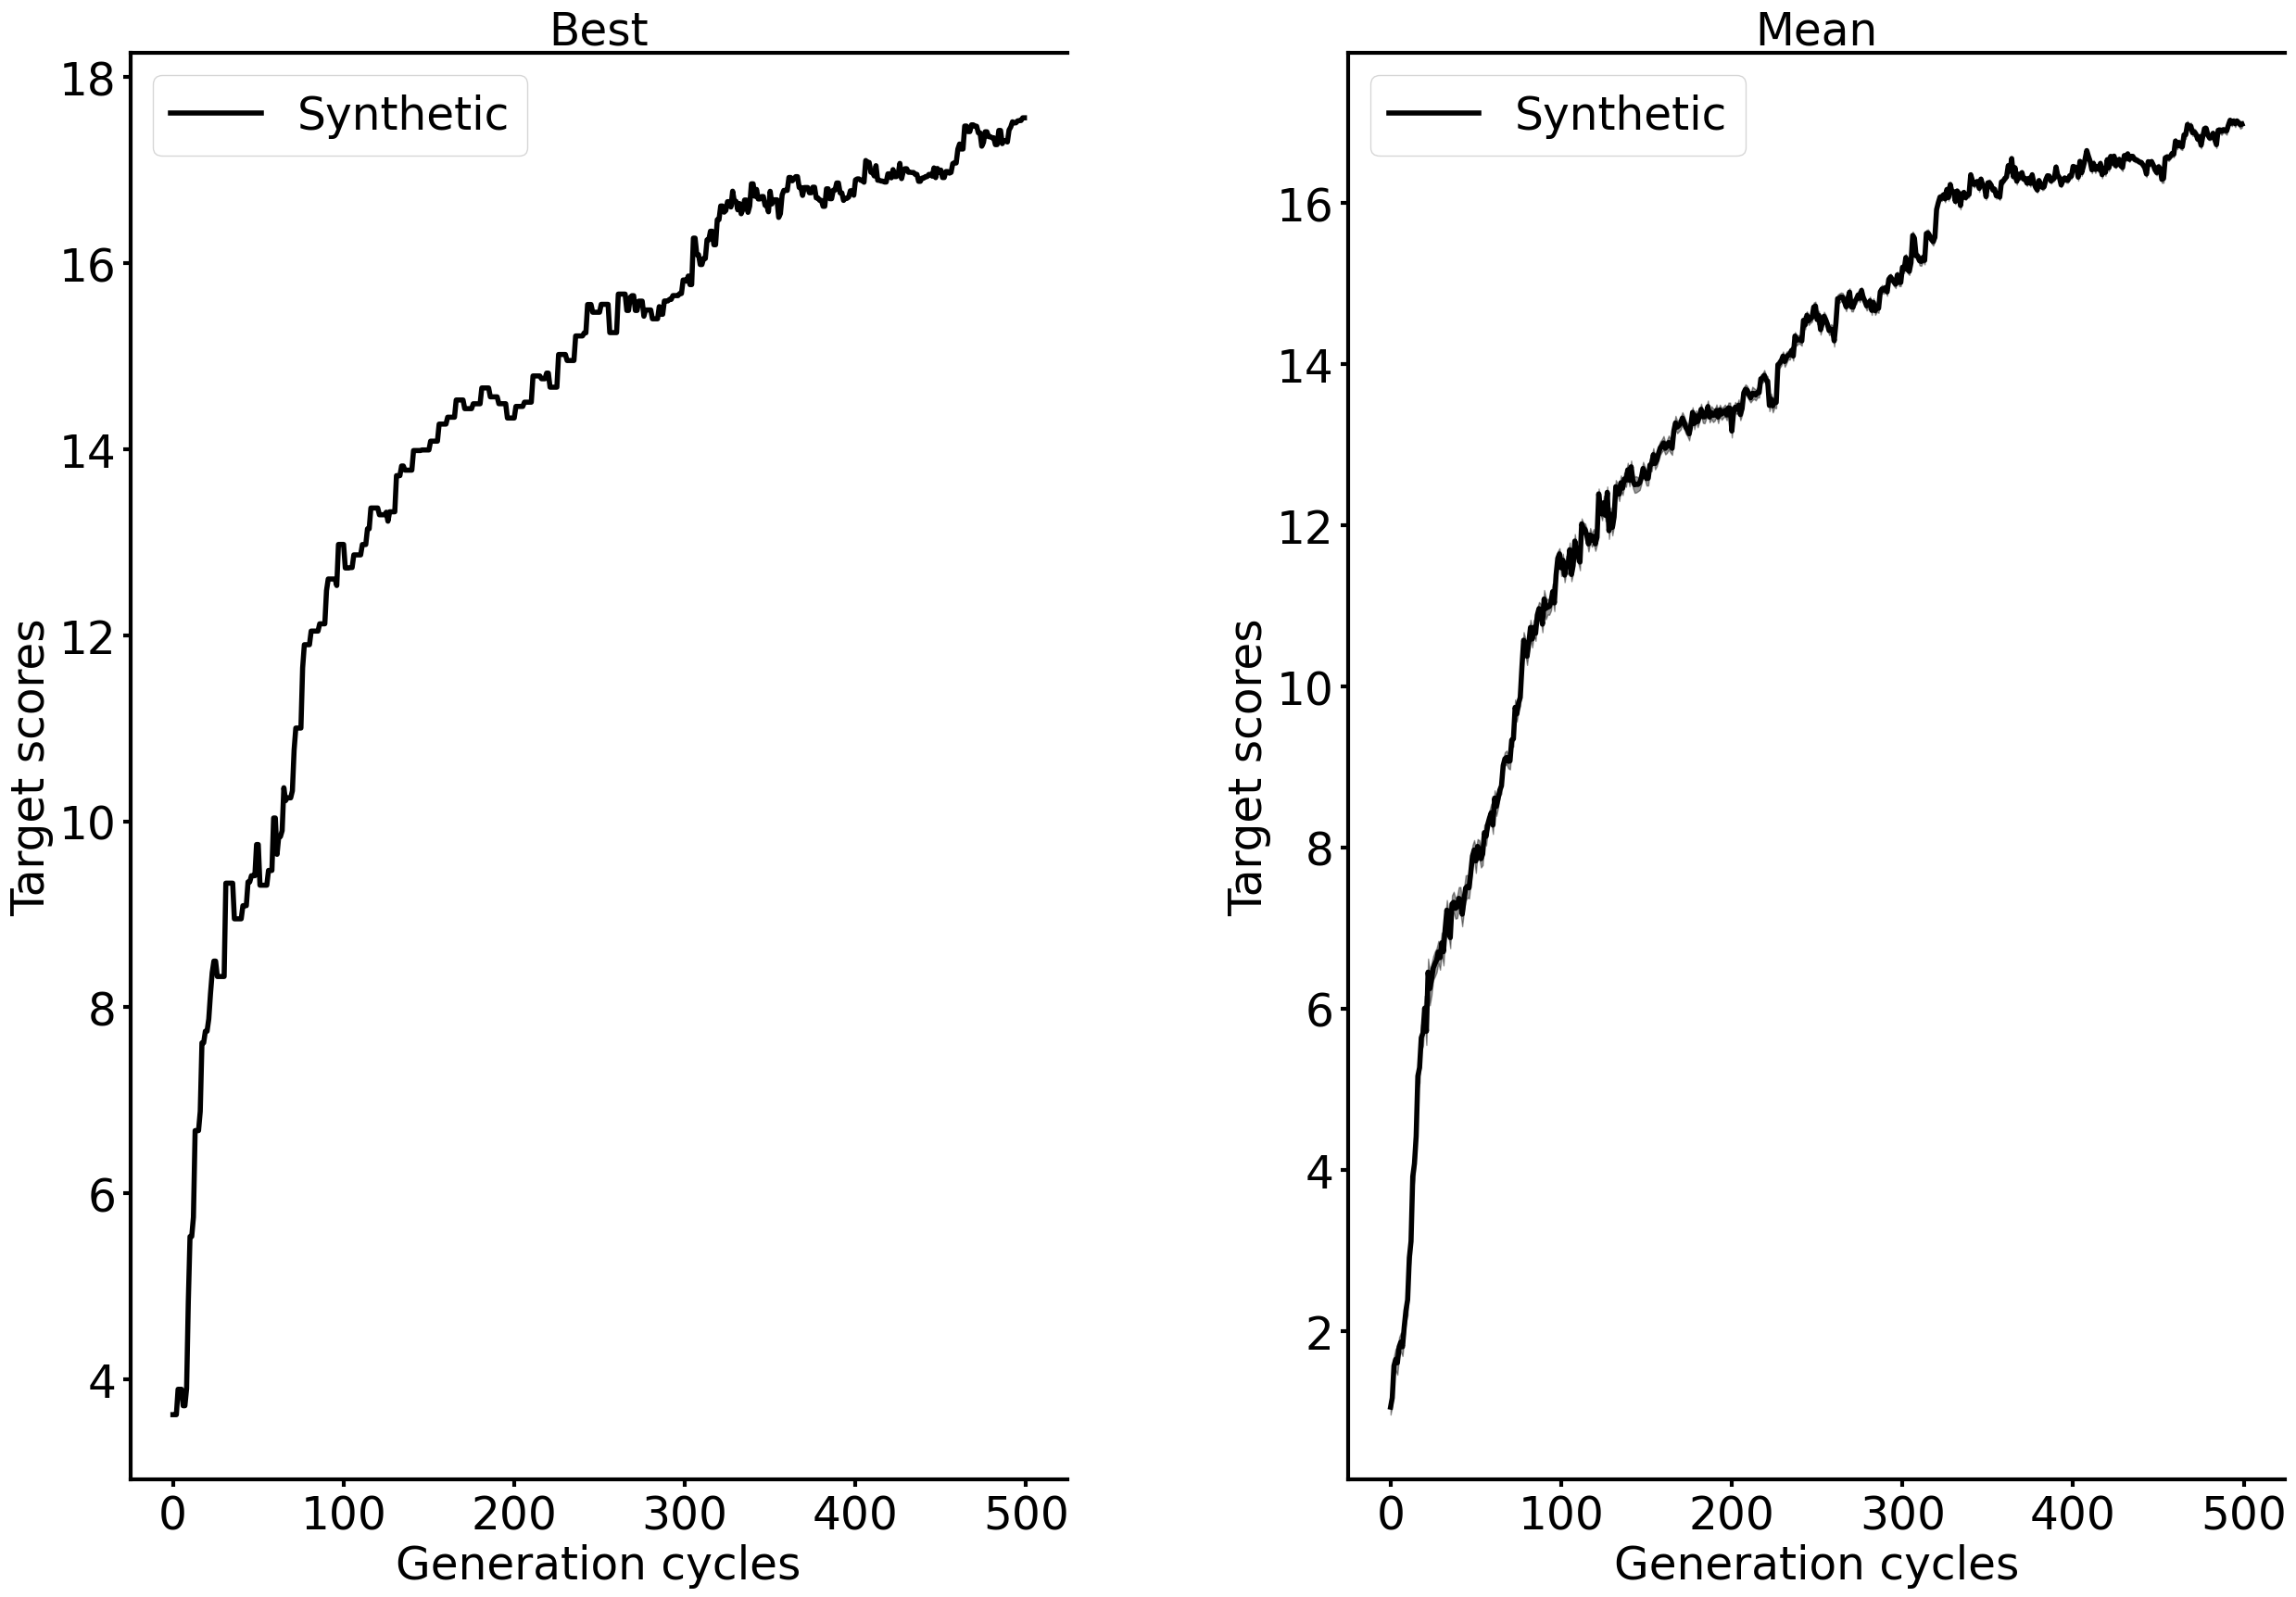

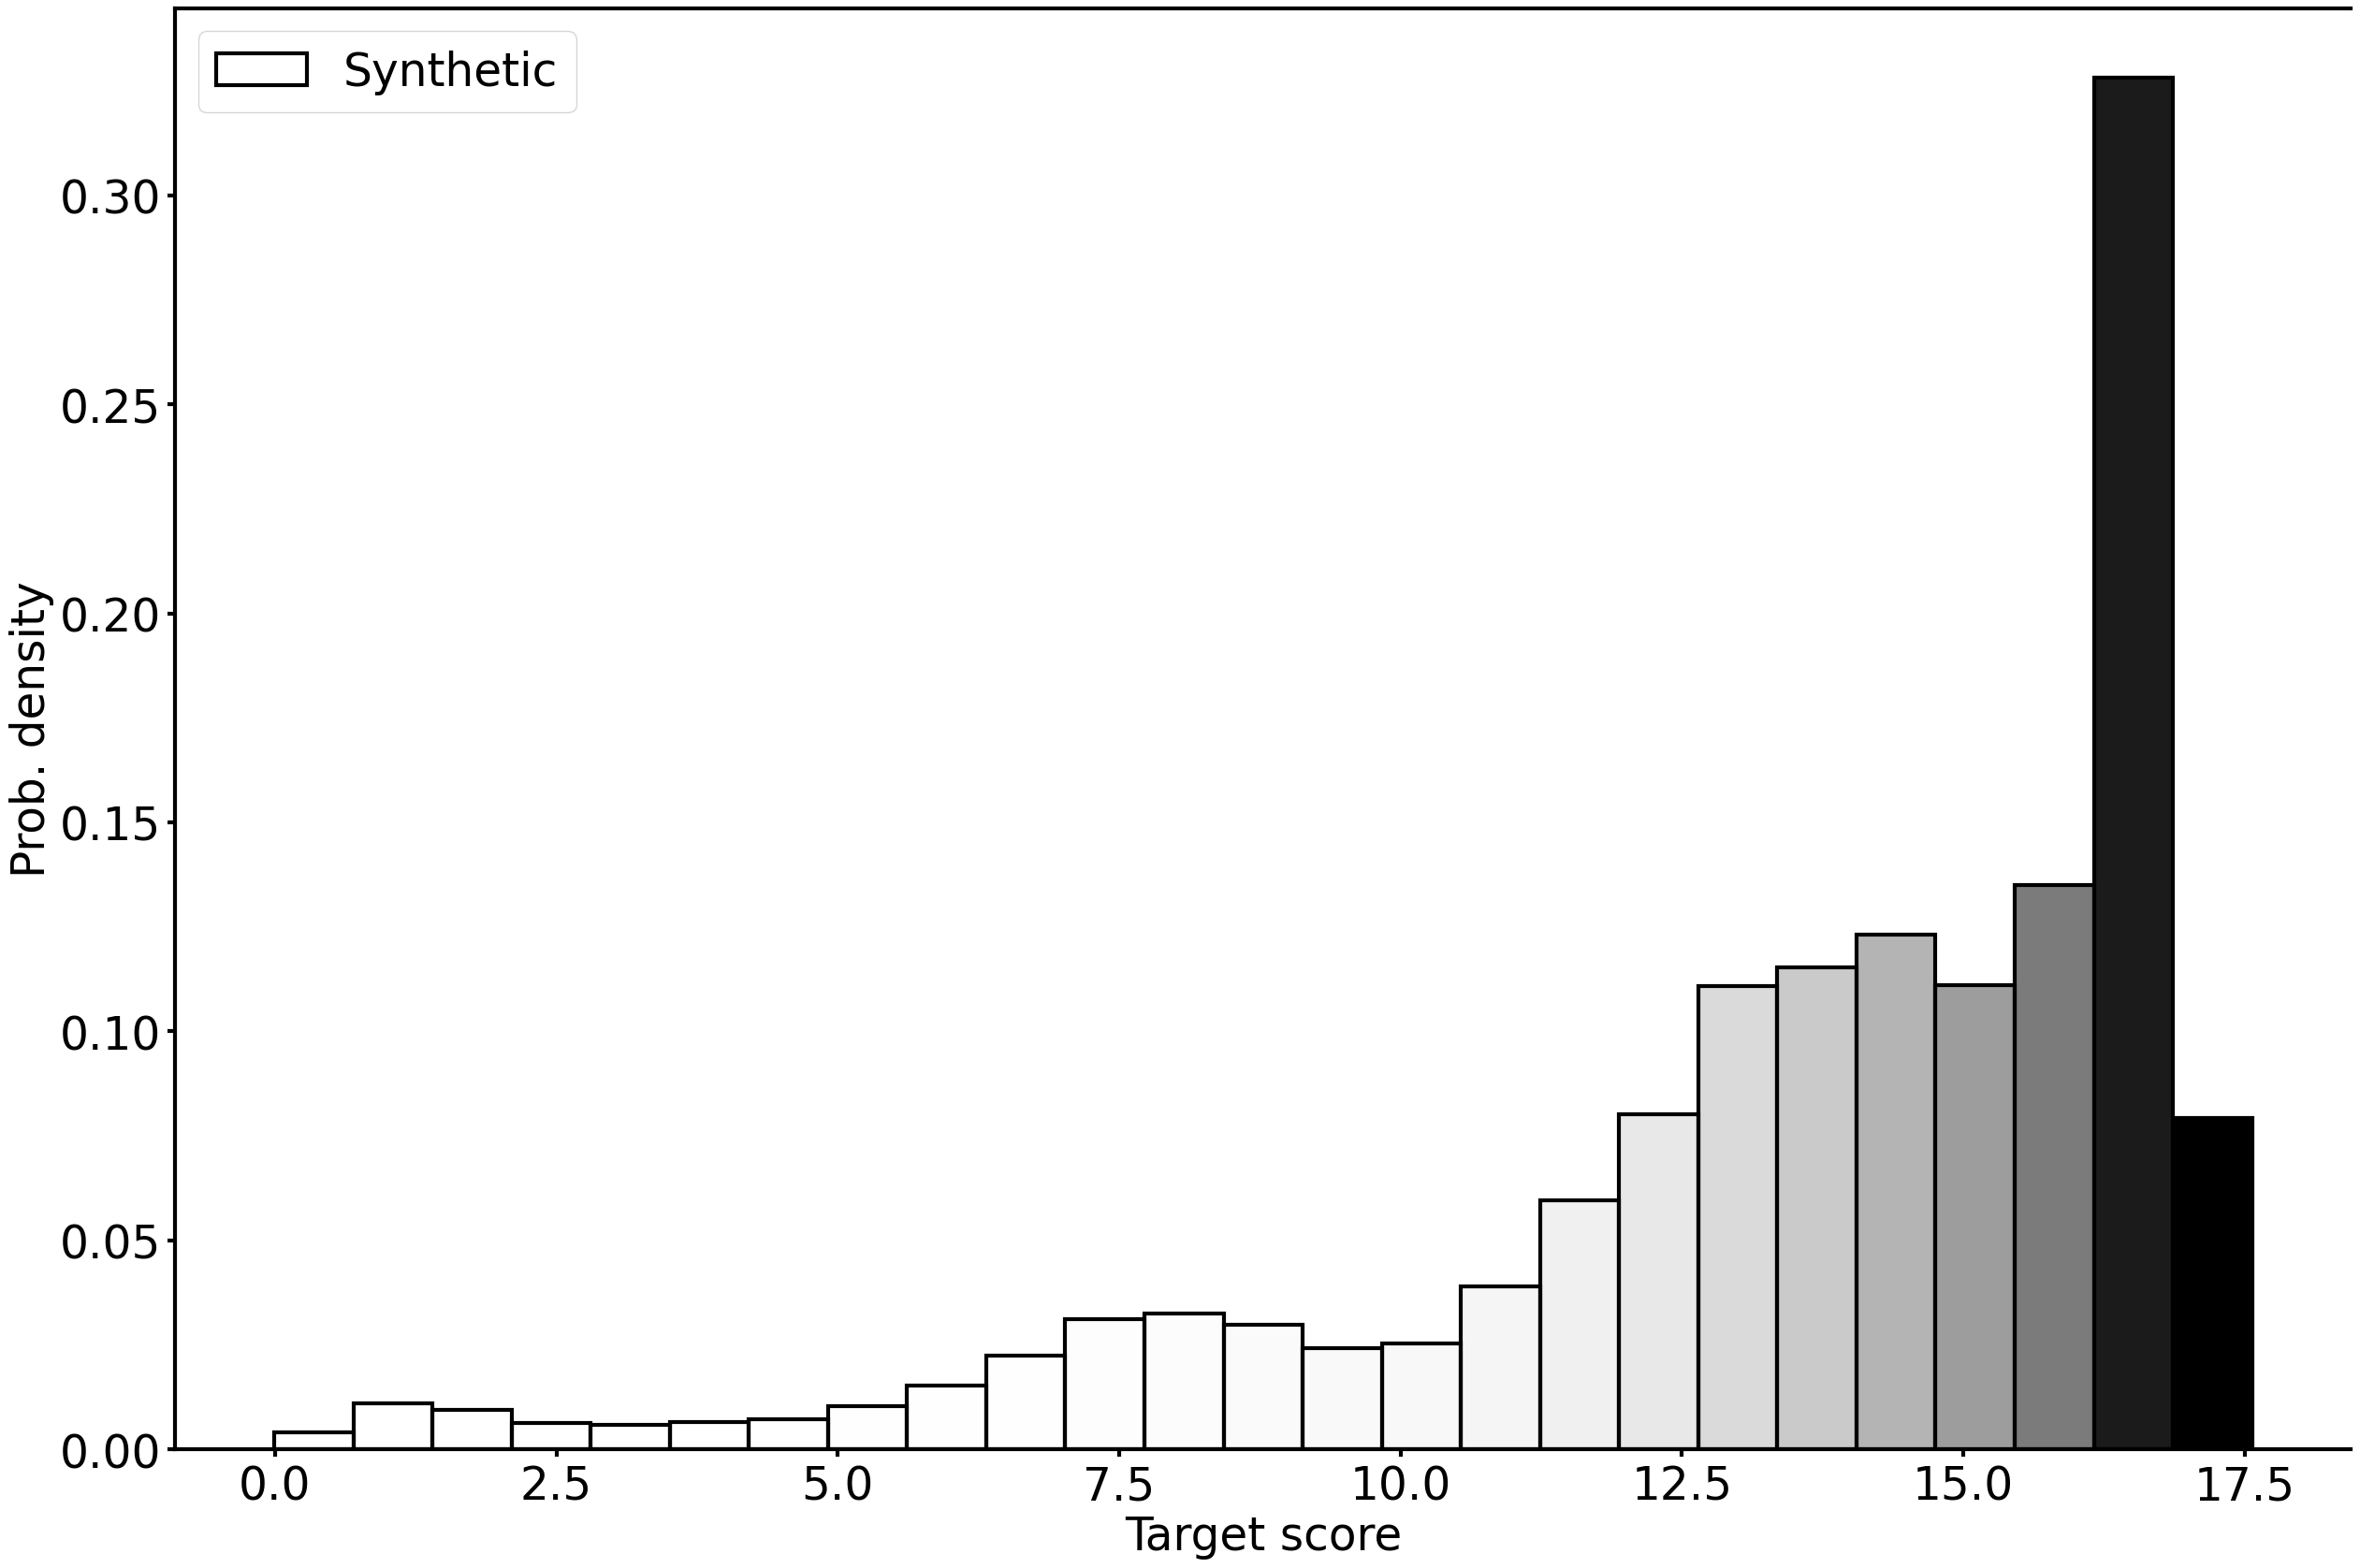

In [2]:
from src.xdream.experiment.maximize_activity import MaximizeActivityExperiment


MA = MaximizeActivityExperiment(generator,
                           sbj_net,
                           scorer,
                           optim,
                           n_iter,
                           logger,
                           nat_img_loader,

                           data,
                           name = 'maximize_activity')


msg = MA.run()

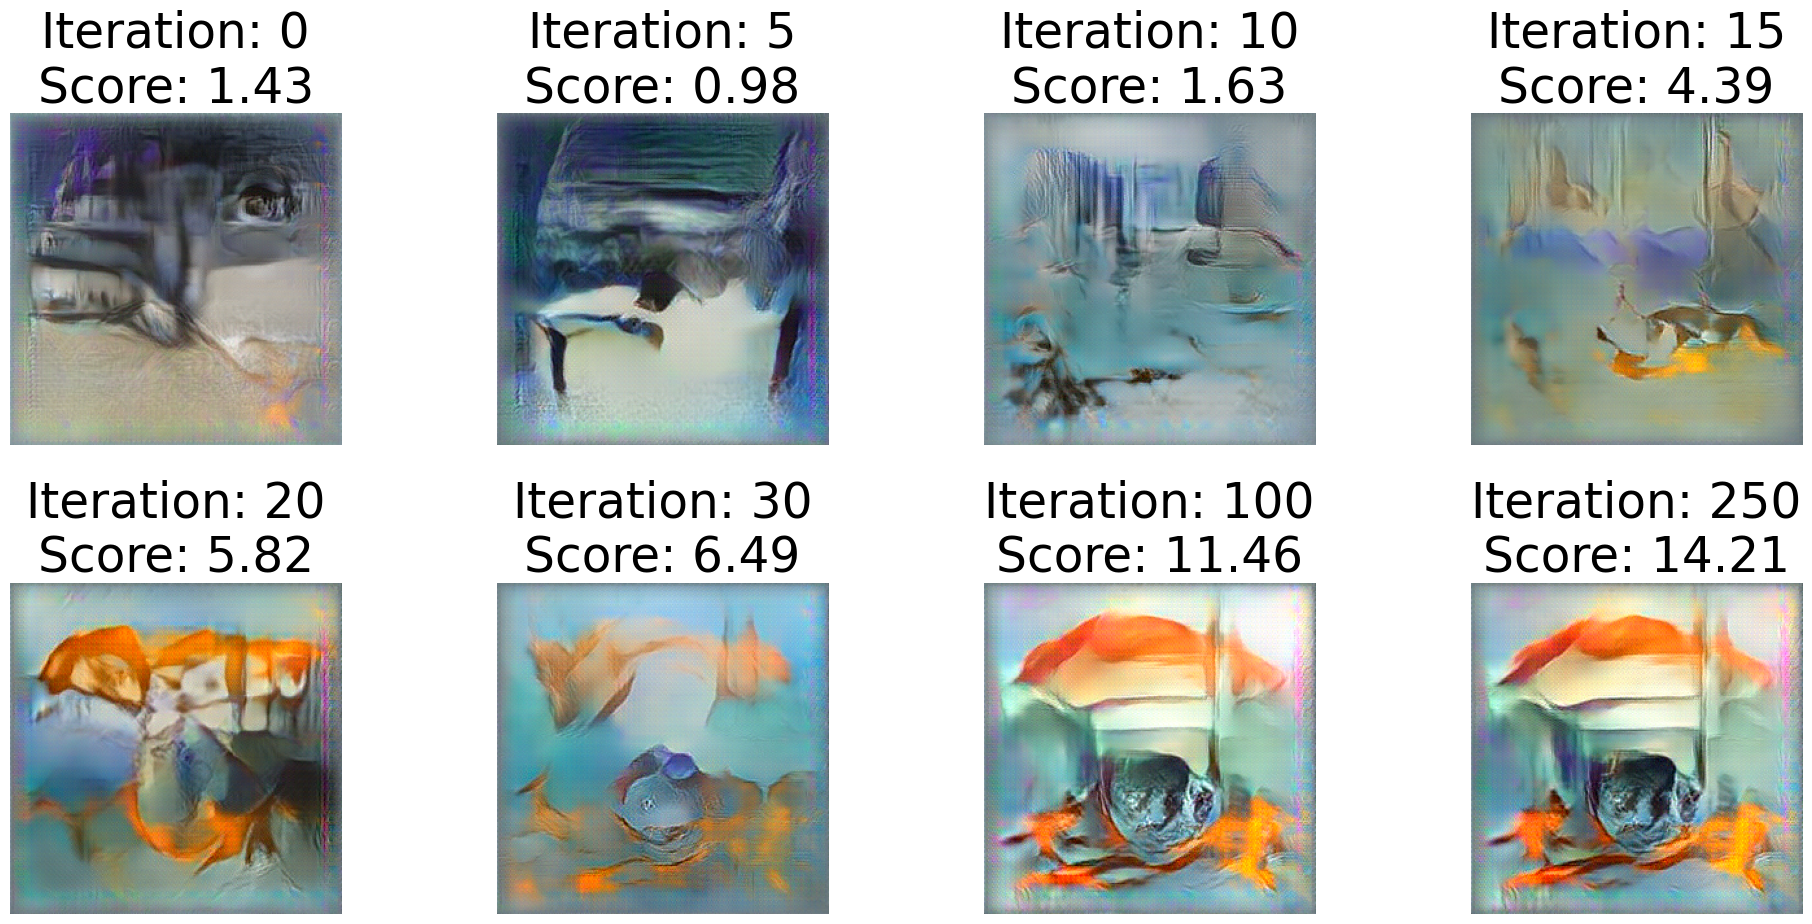

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

codes= np.load('path/to/codes.npy')
scores = np.load('path/to/scores_gen.npy')
iteration_steps = [0, 5, 10, 15, 20, 30, 100, 250]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, step in enumerate(iteration_steps):
    row = i // 4
    col = i % 4
    
    selected_code = codes[step:step+1, 10, :]
    
    im = generator(codes=selected_code)
    
    img_np = im[0].cpu().detach().numpy()
    img_plt = np.transpose(img_np, (1, 2, 0))
    img_plt = (img_plt - img_plt.min()) / (img_plt.max() - img_plt.min())
    
    state_value = scores[step, 10]
    
    ax = axes[row, col]
    ax.imshow(img_plt)
    ax.set_title(f'Iteration: {step}\nScore: {state_value:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## PLOTS AND ANALYSIS


In [11]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
file_path = os.path.expanduser('path/to/data.pkl')

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# The structure of `data` is :
# data['optim_scores'][unit][optimizer_type] = {
#     'mean': (array of shape [n_repetitions, n_iterations]),
#     'best': (array of shape [n_repetitions, n_iterations]),
#     'elapsed_time': (list or array of times, one per repetition)
# }

units = list(data['optim_scores'].keys())
optimizers = ['genetic', 'hybrid', 'cmaes']


In [13]:
def global_mean(opttype):
    """
    Computes the average "mean scores" across all units at each iteration, 
    as well as the corresponding SEM (standard error of the mean).
    """
    averaged_list = []
    for unit in units:
        # shape: [n_repetitions, n_iterations]
        arr = data['optim_scores'][unit][opttype]['mean']
        # mean across repeated runs at each iteration
        mean_per_iter = np.mean(arr, axis=0)
        averaged_list.append(mean_per_iter)
    averaged_list = np.array(averaged_list)  # shape: [n_units, n_iterations]
    
    g_mean = np.mean(averaged_list, axis=0)
    g_sem = np.std(averaged_list, axis=0) / np.sqrt(averaged_list.shape[0])
    return g_mean, g_sem

def best_final_score(unit, opttype):
    """
    Returns the best final score for a given unit and optimizer.
    'best' has shape [n_repetitions, n_iterations], so we take max over all reps and all iterations.
    """
    return np.max(data['optim_scores'][unit][opttype]['best'])

def average_time(unit, opttype):
    """
    Returns the average elapsed time over all runs for a given unit and optimizer.
    """
    return np.mean(data['optim_scores'][unit][opttype]['elapsed_time'])

def score_time_ratio(unit, opttype):
    """
    Returns the ratio of final best score to average time (a simple measure of 
    'score per second' for each unit and optimizer).
    """
    return best_final_score(unit, opttype) / average_time(unit, opttype)


In [16]:
elapsed_times_dict = {
    opt: [average_time(u, opt) for u in units] for opt in optimizers
}

# Global means (and SEM) across iterations
means_and_sems = {
    opt: global_mean(opt) for opt in optimizers
}

iterations = np.arange(0, 500, 1)

# Per-unit maximum and mean
max_scores_dict = { 
    opt: [ np.max(data['optim_scores'][u][opt]['best']) for u in units ] 
    for opt in optimizers
}
mean_scores_dict = {
    opt: [ np.mean(data['optim_scores'][u][opt]['mean']) for u in units ]
    for opt in optimizers
}

# Final best score for each unit and each optimizer
final_best_scores = {
    opt: [best_final_score(u, opt) for u in units] for opt in optimizers
}



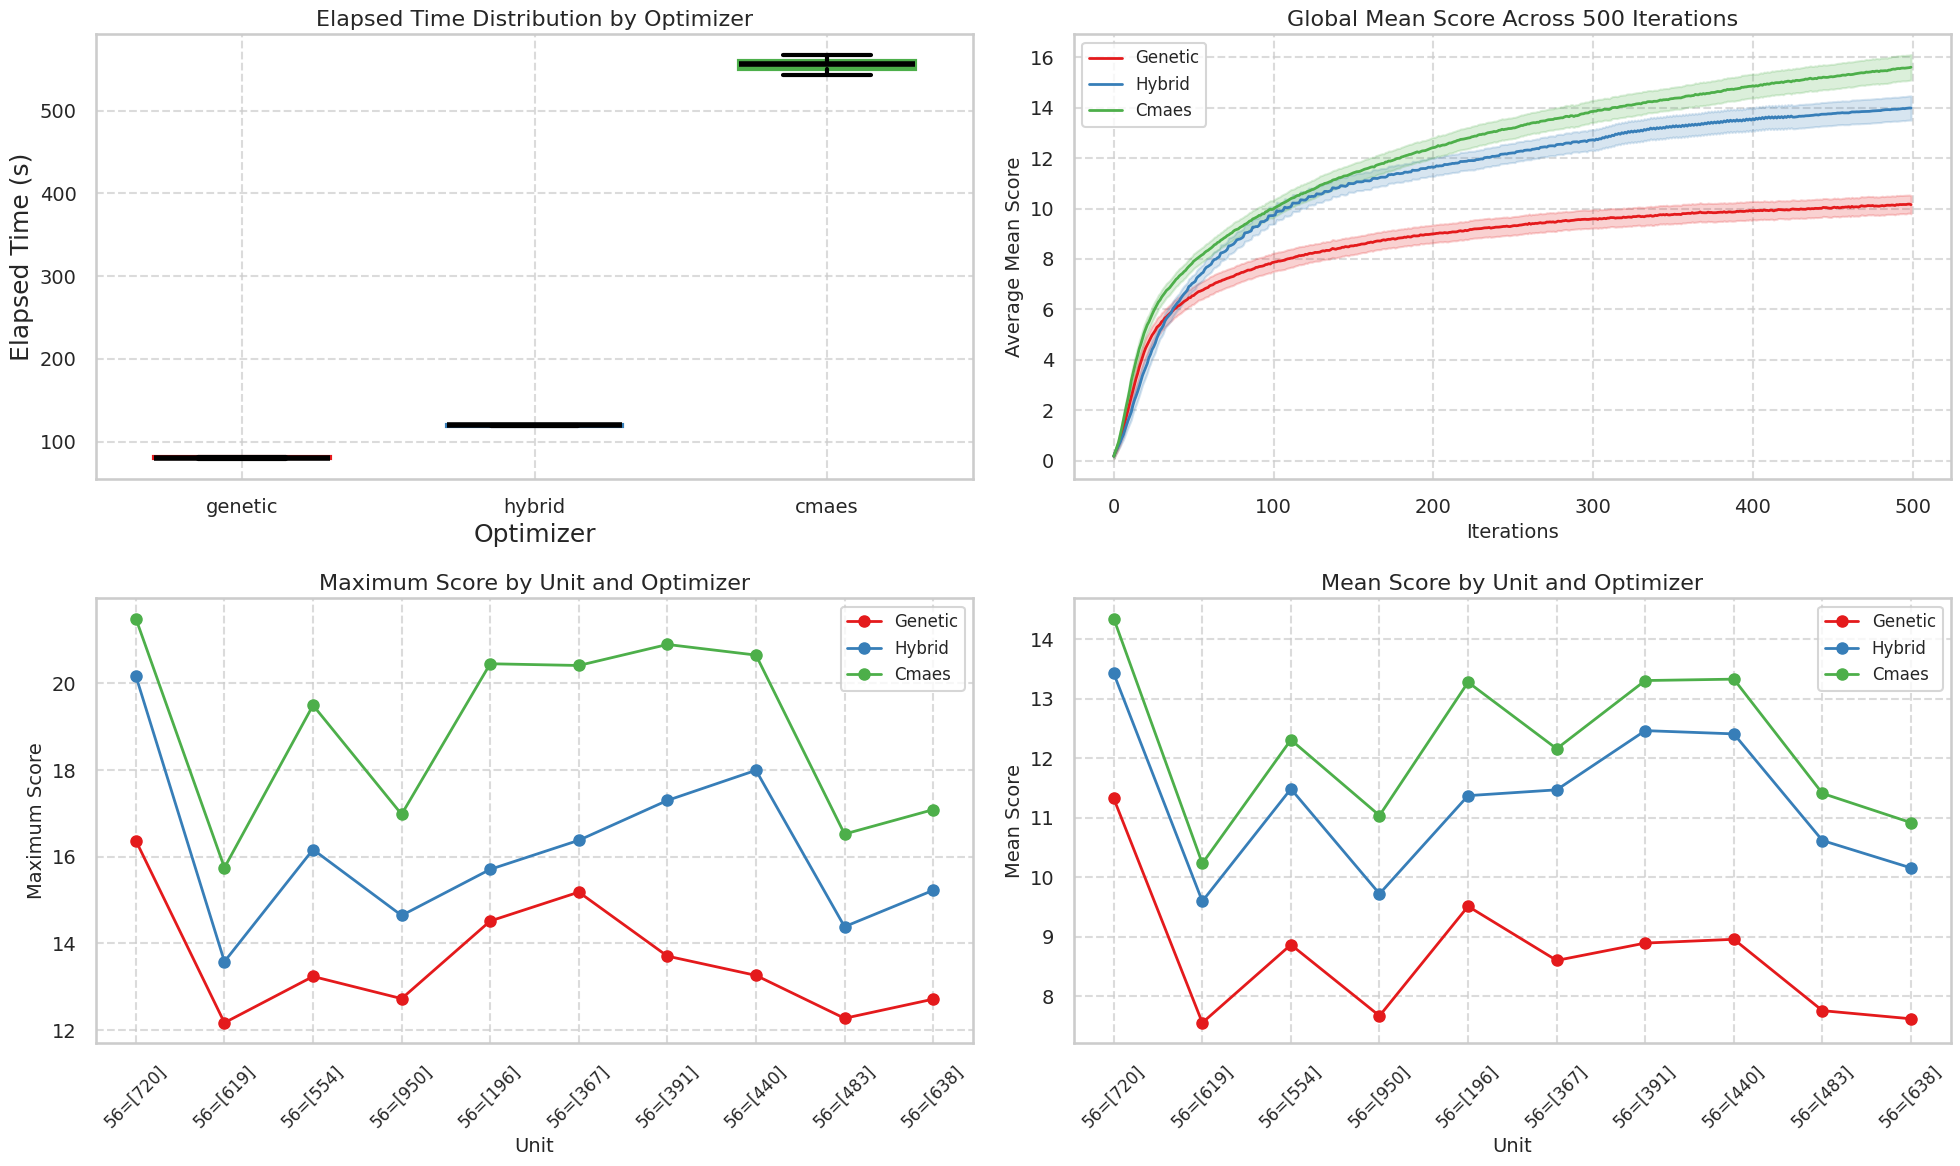

<Figure size 3000x2000 with 0 Axes>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_context("talk", font_scale=1.0)

colors = sns.color_palette("Set1", n_colors=len(optimizers))  # expecting optimizers = ['genetic', 'hybrid', 'cmaes']

fig1, axs1 = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

ax = axs1[0, 0]
all_times = [elapsed_times_dict[opt] for opt in optimizers]
bp = ax.boxplot(all_times, labels=optimizers, patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
for median in bp['medians']:
    median.set_color('black')

ax.set_xlabel('Optimizer')
ax.set_ylabel('Elapsed Time (s)')
ax.set_title('Elapsed Time Distribution by Optimizer', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

ax = axs1[0, 1]
for opt, color in zip(optimizers, colors):
    g_mean, g_sem = means_and_sems[opt]
    ax.plot(iterations, g_mean, label=opt.capitalize(), color=color, linewidth=2)
    ax.fill_between(iterations, g_mean - g_sem, g_mean + g_sem, color=color, alpha=0.2)

ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Average Mean Score', fontsize=14)
ax.set_title('Global Mean Score Across 500 Iterations', fontsize=16)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

ax = axs1[1, 0]
for opt, color in zip(optimizers, colors):
    ax.plot(units, max_scores_dict[opt], label=opt.capitalize(), color=color, marker='o', markersize=8, linewidth=2)

ax.set_xlabel('Unit', fontsize=14)
ax.set_ylabel('Maximum Score', fontsize=14)
ax.set_title('Maximum Score by Unit and Optimizer', fontsize=16)
ax.legend(fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

ax = axs1[1, 1]
for opt, color in zip(optimizers, colors):
    ax.plot(units, mean_scores_dict[opt], label=opt.capitalize(), color=color, marker='o', markersize=8, linewidth=2)

ax.set_xlabel('Unit', fontsize=14)
ax.set_ylabel('Mean Score', fontsize=14)
ax.set_title('Mean Score by Unit and Optimizer', fontsize=16)
ax.legend(fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


## Hybrid opt params tuning multi-experiment

Available layers: ['56=[399]', '56=[835]', '56=[816]', '56=[365]', '56=[570]', '56=[325]', '56=[673]', '56=[896]', '56=[509]', '56=[536]']
Parameter sets tested: ['set1', 'set2', 'set3', 'set4']


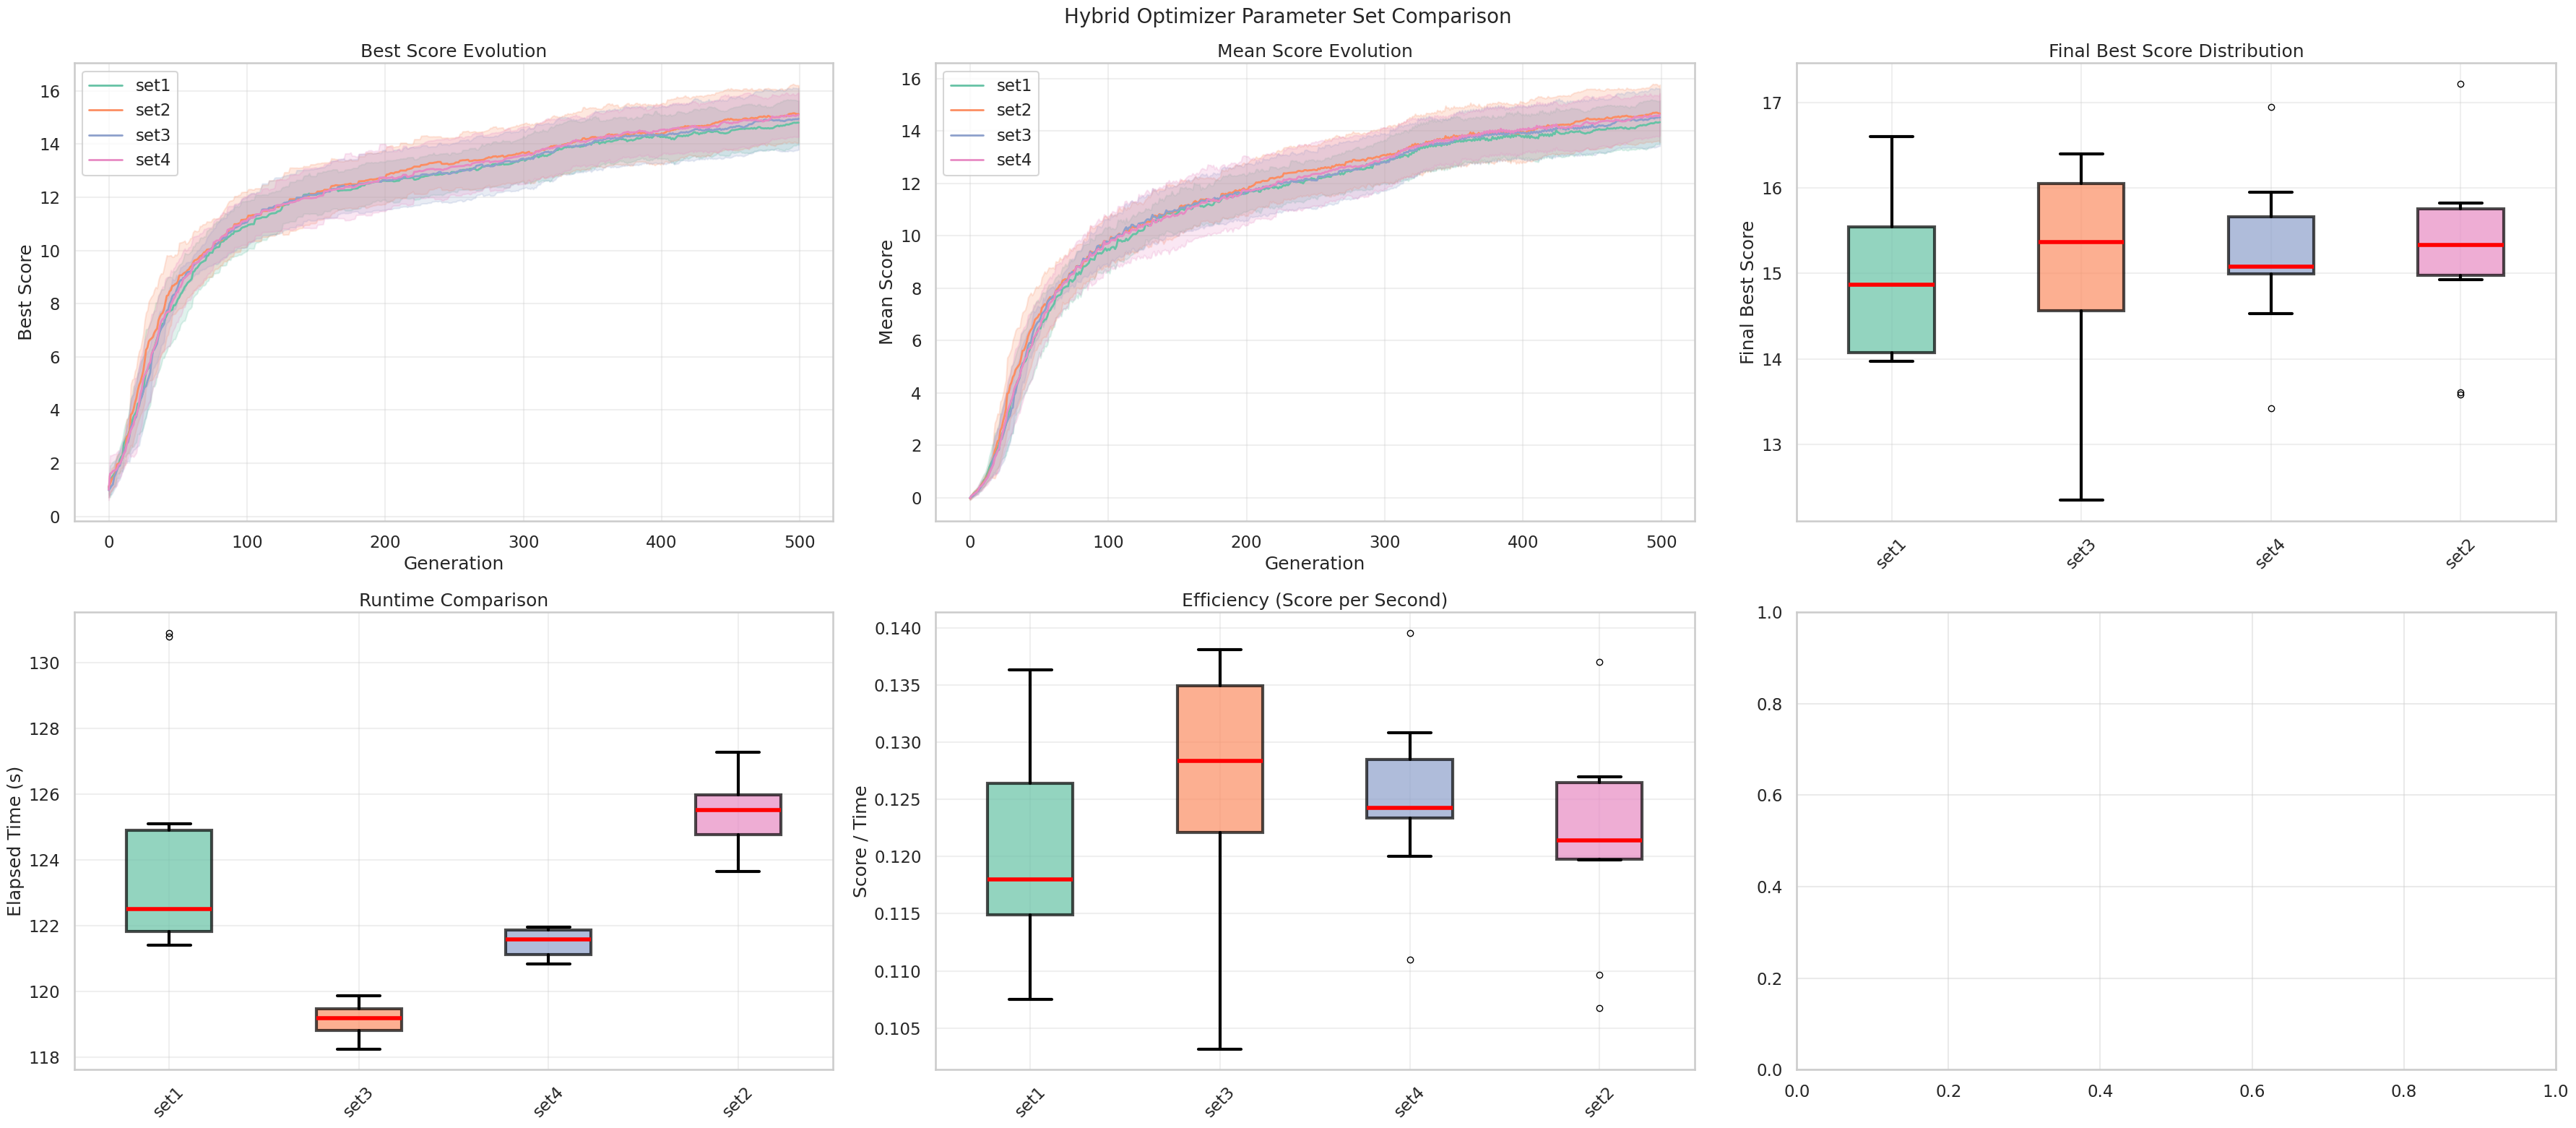


HYBRID OPTIMIZER PARAMETER SET ANALYSIS SUMMARY
Parameter Set   Avg Final Score    Std Final Score    Avg Time (s)    Efficiency  
--------------------------------------------------------------------------------
set1            14.914             0.864              124.30          0.1200      
set2            15.244             1.015              125.46          0.1215      
set3            15.076             1.185              119.15          0.1265      
set4            15.205             0.877              121.49          0.1252      

WINNERS BY CRITERIA:                              
--------------------------------------------------
Best Average Final Score: set2 (15.244)
Fastest Runtime: set3 (119.15s)
Most Efficient (Score/Time): set3 (0.1265)

BEST PARAMETER SET DETAILS (set2):
--------------------------------------------------
inertia_max              : 0.99
inertia_min              : 0.95
cognitive                : 2
social                   : 1.2
v_clip                   :

In [19]:


import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the hybrid parameter experiment data

param_exp_file_path = os.path.expanduser('/home/gamerio/Desktop/hybridoutput/MaximizeActivity/2_07_optparams_varyingGen/data.pkl')

try:
    with open(param_exp_file_path, 'rb') as f:
        param_data = pickle.load(f)
    
    # The structure of `param_data` is:
    # param_data['optim_scores'][layer][param_set] = {
    #     'mean_gens': (array of mean scores across generations),
    #     'best_gens': (array of best scores across generations), 
    #     'elapsed_time': (list of elapsed times),
    #     'params': (dict of actual parameter values used)
    # }
    
    layers = list(param_data['optim_scores'].keys())
    print(f"Available layers: {layers}")
    
    target_layer = layers[0] if layers else None
    
    if target_layer:
        param_sets = list(param_data['optim_scores'][target_layer].keys())
        print(f"Parameter sets tested: {param_sets}")
        
        # Set up plotting style
        sns.set_style("whitegrid")
        sns.set_context("talk", font_scale=1.0)
        colors = sns.color_palette("Set2", n_colors=len(param_sets))
        
      
        
        fig, axs = plt.subplots(2, 3, figsize=(36, 16))
        plt.suptitle('Hybrid Optimizer Parameter Set Comparison', fontsize=20, y=0.98)
        
        ax = axs[0, 0]
        for param_set, color in zip(param_sets, colors):
            best_gens = param_data['optim_scores'][target_layer][param_set]['best_gens']
            if len(best_gens) > 0:
                best_array = np.array(best_gens)
                if best_array.ndim > 1:
                    mean_best = np.mean(best_array, axis=0)
                    std_best = np.std(best_array, axis=0)
                    iterations = np.arange(len(mean_best))
                    ax.plot(iterations, mean_best, label=f'{param_set}', color=color, linewidth=2)
                    ax.fill_between(iterations, mean_best - std_best, mean_best + std_best, 
                                   color=color, alpha=0.2)
                else:
                    iterations = np.arange(len(best_array))
                    ax.plot(iterations, best_array, label=f'{param_set}', color=color, linewidth=2)
        
        ax.set_xlabel('Generation')
        ax.set_ylabel('Best Score')
        ax.set_title('Best Score Evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax = axs[0, 1]
        for param_set, color in zip(param_sets, colors):
            mean_gens = param_data['optim_scores'][target_layer][param_set]['mean_gens']
            if len(mean_gens) > 0:
                mean_array = np.array(mean_gens)
                if mean_array.ndim > 1:
                    mean_mean = np.mean(mean_array, axis=0)
                    std_mean = np.std(mean_array, axis=0)
                    iterations = np.arange(len(mean_mean))
                    ax.plot(iterations, mean_mean, label=f'{param_set}', color=color, linewidth=2)
                    ax.fill_between(iterations, mean_mean - std_mean, mean_mean + std_mean,
                                   color=color, alpha=0.2)
                else:
                    iterations = np.arange(len(mean_array))
                    ax.plot(iterations, mean_array, label=f'{param_set}', color=color, linewidth=2)
        
        ax.set_xlabel('Generation')
        ax.set_ylabel('Mean Score')
        ax.set_title('Mean Score Evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax = axs[0, 2]
        final_best_scores = []
        param_labels = []
        for param_set in param_sets:
            best_gens = param_data['optim_scores'][target_layer][param_set]['best_gens']
            if len(best_gens) > 0:
                best_array = np.array(best_gens)
                if best_array.ndim > 1:
                    final_scores = np.max(best_array, axis=1)  # Max score per run
                    final_best_scores.extend(final_scores)
                    param_labels.extend([param_set] * len(final_scores))
                else:
                    final_best_scores.append(np.max(best_array))
                    param_labels.append(param_set)
        
        unique_params = list(set(param_labels))
        grouped_scores = [[] for _ in unique_params]
        for score, label in zip(final_best_scores, param_labels):
            idx = unique_params.index(label)
            grouped_scores[idx].append(score)
        
        bp = ax.boxplot(grouped_scores, labels=unique_params, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(unique_params)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel('Final Best Score')
        ax.set_title('Final Best Score Distribution')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        ax = axs[1, 0] 
        elapsed_times = []
        param_labels_time = []
        for param_set in param_sets:
            times = param_data['optim_scores'][target_layer][param_set]['elapsed_time']
            if len(times) > 0:
                elapsed_times.extend(times)
                param_labels_time.extend([param_set] * len(times))
        
        grouped_times = [[] for _ in unique_params]
        for time_val, label in zip(elapsed_times, param_labels_time):
            idx = unique_params.index(label)
            grouped_times[idx].append(time_val)
        
        bp = ax.boxplot(grouped_times, labels=unique_params, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(unique_params)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel('Elapsed Time (s)')
        ax.set_title('Runtime Comparison')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        ax = axs[1, 1]
        score_time_ratios = []
        param_labels_ratio = []
        
        for param_set in param_sets:
            best_gens = param_data['optim_scores'][target_layer][param_set]['best_gens']
            times = param_data['optim_scores'][target_layer][param_set]['elapsed_time']
            
            if len(best_gens) > 0 and len(times) > 0:
                best_array = np.array(best_gens)
                if best_array.ndim > 1:
                    final_scores = np.max(best_array, axis=1)
                    ratios = final_scores / np.array(times)
                else:
                    ratios = [np.max(best_array) / times[0]] if times else []
                
                score_time_ratios.extend(ratios)
                param_labels_ratio.extend([param_set] * len(ratios))
        
        grouped_ratios = [[] for _ in unique_params]
        for ratio, label in zip(score_time_ratios, param_labels_ratio):
            idx = unique_params.index(label)
            grouped_ratios[idx].append(ratio)
        
        bp = ax.boxplot(grouped_ratios, labels=unique_params, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(unique_params)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel('Score / Time')
        ax.set_title('Efficiency (Score per Second)')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
       
        plt.tight_layout()
        plt.show()
        
      
        
        print("\n" + "="*80)
        print("HYBRID OPTIMIZER PARAMETER SET ANALYSIS SUMMARY")
        print("="*80)
        
        performance_summary = {}
        for param_set in param_sets:
            best_gens = param_data['optim_scores'][target_layer][param_set]['best_gens']
            times = param_data['optim_scores'][target_layer][param_set]['elapsed_time']
            
            if len(best_gens) > 0:
                best_array = np.array(best_gens)
                if best_array.ndim > 1:
                    avg_final_score = np.mean(np.max(best_array, axis=1))
                    std_final_score = np.std(np.max(best_array, axis=1))
                else:
                    avg_final_score = np.max(best_array)
                    std_final_score = 0
                
                avg_time = np.mean(times) if times else 0
                efficiency = avg_final_score / avg_time if avg_time > 0 else 0
                
                performance_summary[param_set] = {
                    'avg_final_score': avg_final_score,
                    'std_final_score': std_final_score,
                    'avg_time': avg_time,
                    'efficiency': efficiency
                }
        
        print(f"{'Parameter Set':<15} {'Avg Final Score':<18} {'Std Final Score':<18} {'Avg Time (s)':<15} {'Efficiency':<12}")
        print("-" * 80)
        for param_set, metrics in performance_summary.items():
            print(f"{param_set:<15} {metrics['avg_final_score']:<18.3f} {metrics['std_final_score']:<18.3f} "
                  f"{metrics['avg_time']:<15.2f} {metrics['efficiency']:<12.4f}")
        
        print(f"\n{'WINNERS BY CRITERIA:':<50}")
        print("-" * 50)
        
        best_score_set = max(performance_summary.keys(), 
                           key=lambda x: performance_summary[x]['avg_final_score'])
        print(f"Best Average Final Score: {best_score_set} ({performance_summary[best_score_set]['avg_final_score']:.3f})")
        
        fastest_set = min(performance_summary.keys(),
                         key=lambda x: performance_summary[x]['avg_time'])
        print(f"Fastest Runtime: {fastest_set} ({performance_summary[fastest_set]['avg_time']:.2f}s)")
        
        most_efficient_set = max(performance_summary.keys(),
                               key=lambda x: performance_summary[x]['efficiency'])
        print(f"Most Efficient (Score/Time): {most_efficient_set} ({performance_summary[most_efficient_set]['efficiency']:.4f})")
        
        print(f"\nBEST PARAMETER SET DETAILS ({best_score_set}):")
        print("-" * 50)
        best_params = param_data['optim_scores'][target_layer][best_score_set]['params']
        for param_name, param_value in best_params.items():
            print(f"{param_name:<25}: {param_value}")
        
    else:
        print("No data available in the pickle file.")
        
except FileNotFoundError:
    print(f"File not found: {param_exp_file_path}")
    print("Please check the path and make sure the experiment has been run.")
except Exception as e:
    print(f"Error loading data: {e}")